In [137]:
import torch
from datasets import load_dataset
from jupyter_server.transutils import trans
from jupyterlab.semver import valid
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import einops
import numpy as np
import torchvision.transforms as transforms

In [160]:
# ds = load_dataset("pittawat/letter_recognition")
# ds = load_dataset("AI-Lab-Makerere/beans")
# ds = load_dataset("benschill/brain-tumor-collection", trust_remote_code=True)
# ds = load_dataset("uoft-cs/cifar100")
ds = load_dataset("microsoft/cats_vs_dogs")

Generating train split: 100%|██████████| 23410/23410 [00:01<00:00, 19974.86 examples/s]


In [161]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

In [165]:
def get_dataset(name, batch_size):
    """
    input: str -> name of the dataset
    return: DataLoader, DataLoader -> train, test splits as torch datasets (keys "image" and "label")
    """
    if name == "letter_recognition":
        return _letter_recognition(batch_size)
    
    elif name == "beans":
        return _beans(batch_size)

    elif name == "brain_tumor":
        return _brain_tumor(batch_size)
    
    elif name == "cifar":
        return _cifar(batch_size)
    
    elif name == "cats_and_dogs":
        return _cats_and_dogs(batch_size)
    
    else:
        raise NotImplementedError(name)


def _letter_recognition(batch_size, validation_percent=0.20):
    dataset = load_dataset("pittawat/letter_recognition")
    dataset = dataset.with_format("torch")
    train = dataset["train"]
    test = dataset["test"]
    
    # create validation split
    validation_size = int(len(train) * validation_percent)
    train_size = len(train) - validation_size
    train_split, validation_split = random_split(train, [train_size, validation_size])
    
    # create data loaders
    loader_train = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    loader_validation = DataLoader(validation_split, batch_size=batch_size)
    loader_test = DataLoader(test, batch_size=batch_size)
    
    return loader_train, loader_validation, loader_test
    
    
def _beans(batch_size):
    dataset = load_dataset("AI-Lab-Makerere/beans")
    dataset = dataset.rename_column("labels", "label")
    dataset = dataset.with_format("torch")
    
    train = dataset["train"]
    validation = dataset["validation"]
    test = dataset["test"]

    # create data loaders
    loader_train = DataLoader(train, batch_size=batch_size, shuffle=True)
    loader_validation = DataLoader(validation, batch_size=batch_size)
    loader_test = DataLoader(test, batch_size=batch_size)
    
    return loader_train, loader_validation, loader_test


def _brain_tumor(batch_size, validation_percent=0.20):
    dataset = load_dataset("benschill/brain-tumor-collection", trust_remote_code=True)

    # apply preprocessing
    image_pipeline = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    
    label_pipeline = transforms.Compose([
        transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.int8)),
    ])
    
    def pre_processing(examples):
        examples["image"] = [image_pipeline(image) for image in examples["image"]]
        examples["label"] = [label_pipeline(label) for label in examples["label"]]
        return examples
        
    dataset.set_transform(pre_processing)    
    train = dataset["train"]
    test = dataset["test"]
    
    # create validation split
    validation_size = int(len(train) * validation_percent)
    train_size = len(train) - validation_size
    train_split, validation_split = random_split(train, [train_size, validation_size])
    
    # create data loaders
    loader_train = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    loader_validation = DataLoader(validation_split, batch_size=batch_size)
    loader_test = DataLoader(test, batch_size=batch_size)
    
    return loader_train, loader_validation, loader_test

def _cifar(batch_size, validation_percent=0.20):
    dataset = load_dataset("uoft-cs/cifar100")

    dataset = dataset.rename_column("img", "image")
    dataset = dataset.remove_columns("fine_label")
    dataset = dataset.rename_column("coarse_label", "label")

    dataset = dataset.with_format("torch")

    train = dataset["train"]
    test = dataset["test"]
    
    # create validation split
    validation_size = int(len(train) * validation_percent)
    train_size = len(train) - validation_size
    train_split, validation_split = random_split(train, [train_size, validation_size])
    
    # create data loaders
    loader_train = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    loader_validation = DataLoader(validation_split, batch_size=batch_size)
    loader_test = DataLoader(test, batch_size=batch_size)
    
    return loader_train, loader_validation, loader_test
    

def _cats_and_dogs(batch_size, validation_percent=0.15, test_percent=0.20):

    dataset = load_dataset("microsoft/cats_vs_dogs")
    dataset = dataset.rename_column("labels", "label")
    
    # apply preprocessing
    image_pipeline = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    
    label_pipeline = transforms.Compose([
        transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.int8)),
    ])
    
    def pre_processing(examples):
        examples["image"] = [image_pipeline(image) for image in examples["image"]]
        examples["label"] = [label_pipeline(label) for label in examples["label"]]
        return examples
        
    dataset.set_transform(pre_processing)    
    train = dataset["train"]
    
    # create validation and test splits
    validation_size = int(len(train) * validation_percent)
    test_size = int(len(train) * test_percent)
    train_size = len(train) - validation_size - test_size
    train_split, validation_split, test_split = random_split(train, [train_size, validation_size, test_size])
    
    # create data loaders
    loader_train = DataLoader(train_split, batch_size=batch_size, shuffle=True)
    loader_validation = DataLoader(validation_split, batch_size=batch_size)
    loader_test = DataLoader(test_split, batch_size=batch_size)
    
    return loader_train, loader_validation, loader_test
    



def plot_image(image, ax=None):
    if ax is None:
        ax = plt.gca()
    image = einops.rearrange(image, "c h w -> h w c")
    ax.imshow(image.cpu().detach().numpy())
    

In [175]:
batch_size = 32
train, validation, test = get_dataset("letter_recognition", batch_size=batch_size)

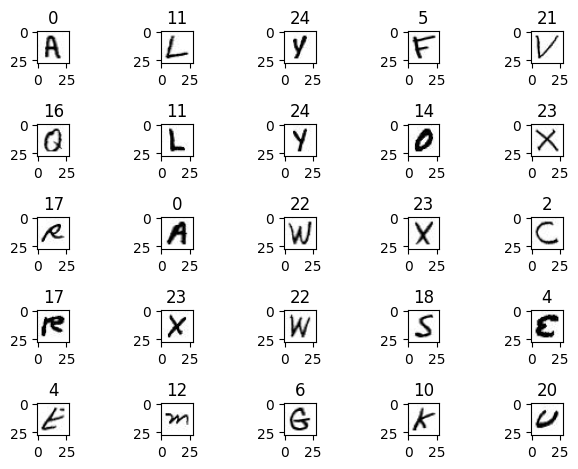

In [176]:
for batch in train:
    x, y = batch["image"], batch["label"]
    N = int(np.sqrt(batch_size))
    fig, axs = plt.subplots(N, N)
    for i in range(N*N):
        ax = axs.flatten()[i]
        plot_image(x[i], ax=ax)
        ax.set_title(f"{y[i].numpy()}")
    fig.tight_layout()
    plt.show()
    break